# Working with Satellite Remote Sensing Data: Ocean Edition
## Focus on ENSO and Marine Heat Waves
### EDS 220 Fall 2021

This week's class will focus on some commonly employed diagnostics used in physical oceanography and climate science, using satellite remote sensing products. 

During the course of this lab exercise, we will cover the following topics/analysis skills:
- Use of OpeNDAP and THREDDS to access data remotely
- Spatial subsetting and regional averaging of data
- Removal of seasonal cycle using "groupby"
- Use of threshold exceedances to identify events (El Nino/La Nina, marine heat waves)
- Performing computations on all gridpoints within a spatial data field
- Creating georeferenced maps of spatial fields using cartopy


#### **Datasets: ERSSTv5 and OISSTv2**
In this lab, we'll be using data from two sources:

- MONTHLY data from the Extended Reconstructed Sea Surface Temperature dataset version 5 (ERSSTv5), to identify El Nino and La Nina periods:
- DAILY data from NOAA's 1/4° Daily Optimum Interpolation Sea Surface Temperature (OISST) version 2, or OISSTv2, to identify marine heat waves. 


#### **OpeNDAP and THREDDS**

The method of accessing these files will be via the NOAA Open-source Project for a Network Data Access Protocol (OpeNDAP) server. OpeNDAP is a fairly common method of providing remote access to large data files without the need to download the entire file; more information can be found here:

https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap

https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap/opendap-user-guide

The OpeNDAP protocol is implemented on many scientific servers using a Web service called the Thematic Real-time Environmental Distributed Data Services (THREDDS), which is responsible for reading in the various metadata fields associated with the appropriate files. More information on THREDDS can be found here:

https://www.unidata.ucar.edu/software/tds/current/

### PART 1: ENSO

First, we will apply the ERSSTv5 product to identify El Nino and La Nina events. The Python packages we will need for this and subsequent parts of the notebook are numpy, matplotlib, cartopy, and xarray:

In [1]:
# Configure environment


The ERSSTv5 data is stored in a single file, containing information for the entire period. The website describing ERSSTv5 data can be found here:

https://psl.noaa.gov/thredds/catalog/Datasets/noaa.ersst.v5/catalog.html?dataset=Datasets/noaa.ersst.v5/sst.mnmean.nc

In [2]:
# location of ERSSTv5 data


In [3]:
# open dataset using remote URL

# display dataset to see what it looks like


Now we can subset this data to extract only information in the NINO3.4 region: 5S-5N, 190-240E (the middle of the Pacific):
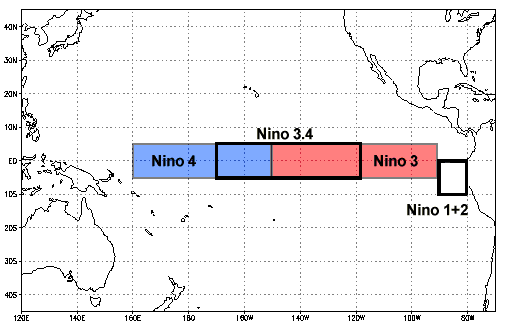

This regional filter will be constructed using _logical masking_: assigning "True" to values within a specified lat/lon range, and "False" to values outside that range. This approach to filtering is nice because it works regardless of the shape or regularity of your data's lat/lon spacing!

In [4]:
# Create logical masks for lat and lon variables


# Apply lat/lon masks to the ERSST field, then calculate averages over the lat and lon dimensions


Let's make a plot to see what this time series looks like!

In [5]:
# create a new figure, set size and resolution (dpi)

# add data to the plot
  
# Specify plot parameters


There is clearly a lot of variability in the time series above, with some years warmer than others: but how do we decide what is really warmer than what would be expected? To do this, we need to remove the effects of seasonal changes in temperature. This is often done by computing the NINO3.4 "SST anomaly", where the mean value for each calendar month is removed (so for January, the average of all Januaries, for February the average of all Februaries, and so on). 

In xarray, the "groupby" functionality allows us to do this quite easily! We can get some basic information on groupby using the `?` syntax:

In [6]:
# Take a look at the groupby method in n34_ts


We need to pass an argument to groupby, to tell it what to use to construct the groups. There are two possible syntaxes for this: the first uses a feature within xarray called the `DateTimeAccessor`, or .dt for short. This is applied to the time variable within the xarray dataframe:

In [7]:
# Display n34_ts DateTimeAccessor


The DateTimeAccessor knows various things about the time that you can query: for instance, the calendar month:

In [8]:
# Query calendar month


Or when variables are already included in the dataframe, you can use a simpler syntax:

In [9]:
# Query calendar month more simply


The above returned what's called a `GroupBy` object, which is essentially a list of groups and which parts of the dataset belong to which group. we can then calculate the monthly mean using this set of groups. Here I will also use the `sel` functionality to select a time period over which to calculate the climatology: 1971-2000 is the "base period" used in the NOAA operational definition of El Nino (more on that below).

Stacking up all our commands, we get:

In [10]:
# Select the 1971-2000 base period, group it by month, and compute a time average for each month


In order to complete our calculation, we next have to _apply_ the GroupBy object to the raw NINO3.4 time series.

The most efficient way (that I know of) to do this is to use the Python "function stacking" capabilities to simultaneously create the groupings and apply them, in a single line of code:

In [11]:
# Create the base period climatology and remove it from the NINO3.4 SST time series

# Display SSTA dataset


In [12]:
# create a new figure, set size and resolution (dpi)
 
# add data to the plot
   
# Set plot parameters


Now that the seasonal cycle has been removed, it's much more obvious when there are large excursions from what is climatologically "normal" for that time of year. 

There are many definitions for El Nino and La Nina events. Here, let's use the one that NOAA uses in its operational ENSO forecasts:
https://www.nws.noaa.gov/ost/climate/STIP/ElNinoDef.htm

This definition states that El Nino is "a positive sea surface temperature departure from normal (for the 1971-2000 base period) in the Niño 3.4 region greater than or equal in magnitude to 0.5 degrees C (0.9 degrees Fahrenheit), averaged over three consecutive months." with La Nina being the same thing, but using a threshold of -0.5C. 

Since we want signals that persist over three consecutive months, we'll use the `rolling` method to isolate periods where the running 3-month average is above/below the threshold:

In [13]:
# Calculate 3-month rolling mean NINO3.4 SSTA


# create a new figure, set size and resolution (dpi)
    
# add data to the plot
   
# Set plot parameters


Another powerful data analysis technique is the use of thresholds for _compositing_. In other words: select all parts of a dataset which satisfy some criterion (in this case, exceeding the El Nino/La Nina SSTA threshold) and making an average over those periods.

The below code creates logical masks for the NINO 3.4 SSTA time series which are either:
- True when El Nino, False other times; or
- True when La Nina, False other times:

In [14]:
# Mask for El Nino

# Mask for La Nina


Using these logical masks, and the knowledge that the full set of ERSST data has the same size time dimension as the NINO3.4 SSTA time series, we can then use this to construct a composite of the SST anomaly _patterns_ present during El Nino and La Nina events. 

First, we need to compute a new array, containing spatial fields of SST anomalies. We can do this using the same group by approach we applied to the NINO3.4 time series:

In [15]:
# Calculate base period climatology and remove it from the ERSST field


Now we apply the logical masks to this new SST anomaly field, and average over time to create a composite map:

In [16]:
# Apply El Nino mask and extract the xarray DataArray


# Apply La Nina mask and extract the xarray DataArray


The final step is to plot this as a nicely formatted map! This can be accomplished using the functionality of cartopy.

In [17]:
# Create an object containing the Plate-Carree map projection, centered at 180E

# Create a figure object

# Create an axis object using the specified projection

# Make a filled contour plot of the El Nino SSTA composite using the specified map projection

# Set plot parameters


In [18]:
# Create an object containing the Plate-Carree map projection, centered at 180E

# Create a figure object

# Create an axis object using the specified projection

# Make a filled contour plot of the La Nina SSTA composite using the specified map projection

# Set plot parameters


### **PART II: Marine Heat Waves**

The next example of SST-based data analysis is marine heat waves: these are events where SST is above a (typically very high) local threshold. 

Here we'll use the OISSTv2 data, since we'll need daily resolution. The OISSTv2 data are stored in many files, each containing information for a single year. The base directory where the information is located can be found here:

https://psl.noaa.gov/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.html

We are also only interested in data within the tropical Pacific - that means that we don't have to read in the entire file, only the subset of it within our region of interest.

All of these tasks can be accomplished by combining _spatial subsetting_ with a carefully constructed _for loop_.

First, let's specify some parameters appropriate for accessing the OISST files. Since we know that there will be one file per year, we can store the "base URL" (first part of the filename) and create a sequence of years of interest using the `range()` function:

In [19]:
# NOAA THREDDS server: base URL for all files 
base_url="https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/"

# Naming convention for files: "sst.day.mean.[year].v2.nc"
yrs=range(2013,2019)
print(yrs)

range(2013, 2019)


This combination of information now allows us to open any OISST file. To make things easier, let's work with the anomaly files; these are files which have already had the seasonal climatology subtracted out, so we don't have to do that step again.

As an example, the following will open the file for 1981:

Now let's extend this to read in data over the entire range of years. 

The below code chunk will take a few minutes to run, since the data files we're working with are quite large. Run time was roughly 2-3 minutes during initial testing of this notebook:

In [20]:
nepac_sst=[]     # Blank variable to store output data 

for y in yrs:
    print(y)
    
    # Open the dataset into an xarray object
    
    # Define logical mask to be true in the Northeast Pacific (30-50N, 180-240E)

    # Read in data 
    

2013
2014
2015
2016
2017
2018


Since we have appended each year's data to the initially blank output variable, the data returned is a list of xarray Datasets. We can convert this into a single Dataset containing time information for all years using `xr.concat`:

In [21]:
# Concatenate list of xarray Datasets into a single Dataset, along dimension "time"


# Calculate a regionally averaged time series for the NE Pacific


Now let's try a new analysis: looking at the exceedance of the _daily_ SST anomaly over a given threshold. This is a standard approach used in marine heat wave studies, although the thresholds and persistence times used are not yet as "standardized" as those used in ENSO research.

There is a paper by Hobday et al. (2016) which proposes numerous marine heat wave definitions - let's use this one:
- Daily SST anomaly exceeding the 90th percentile (for 5 or more days)

If we were doing this for real, the 90th percentile value would be calculated using a long baseline (roughly 30 years or more), but we'll "pretend" for now using the 5-year time series above to shorten the data I/O time needed. To make the computation simpler, we'll also ignore the 5-day persistence requirement for now.

The method of calculating percentiles we will use is a numpy function called `percentile`, since xarray itself does not contain a native percentile function. In order to apply this percentile calculation to the xarray dataset, we can use an xarray method called `reduce`: this reduces the size of a dataset by applying a function you pass it as an argument.

The below code chunk will return the 90th percentile of the NE Pacific time series:

Now we can use the same logical masking method to identify all places within the NE Pacific time series which exceed that threshold:

In [22]:
# Mask for MHW


As for the ENSO example, this mask can now be used to composite over all marine heat wave events:

In [23]:
# Apply MHW mask and extract the xarray DataArray


Finally, we make another cartopy plot to display the results!

In [24]:
# Create an object containing the Plate-Carree map projection, centered at 180E

# Create a figure object

# Create an axis object using the specified projection

# Make a filled contour plot of the La Nina SSTA composite using the specified map projection

# Set plot parameters
